# stamps - stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [16]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [17]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = '83F25619-D272-4660-98A2-93AF5CC18D59'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [18]:
lkupclientid = 35 # stamps
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCFL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(24759, 54)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24759 entries, 0 to 24758
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            24759 non-null  int64  
 1   dimCustomerMasterId     24759 non-null  int64  
 2   customerNumber          24759 non-null  object 
 3   year                    24759 non-null  int64  
 4   productGrouping         24759 non-null  object 
 5   totalSpent              24759 non-null  float64
 6   recentDate              24759 non-null  object 
 7   attendancePercent       24759 non-null  float64
 8   renewedBeforeDays       24759 non-null  int64  
 9   isBuyer                 24759 non-null  object 
 10  source_tenure           24759 non-null  int64  
 11  tenure                  24759 non-null  int64  
 12  distToVenue             24759 non-null  float64
 13  totalGames              24759 non-null  int64  
 14  recency                 24759 non-null

### We should specify the features used in our model:

In [20]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (16237, 13)
Unseen Data For Predictions: (2865, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [21]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [22]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8331,0.7258,0.9630,0.8533,0.9048,0.2486,0.2831,0.6830
lr,Logistic Regression,0.8325,0.7337,0.9810,0.8418,0.9061,0.1715,0.2322,0.0760


In [23]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8320,0.7326,0.9631,0.8521,0.9042,0.2420,0.2765
1,0.8283,0.7373,0.9604,0.8505,0.9021,0.2234,0.2550
2,0.8319,0.7103,0.9675,0.8494,0.9046,0.2216,0.2614
3,0.8362,0.7517,0.9639,0.8556,0.9065,0.2642,0.2991
4,0.8261,0.7083,0.9499,0.8551,0.9000,0.2472,0.2691
5,0.8413,0.7366,0.9701,0.8564,0.9097,0.2763,0.3188
6,0.8341,0.7187,0.9639,0.8535,0.9053,0.2533,0.2887
7,0.8413,0.7290,0.9657,0.8590,0.9092,0.2949,0.3309
8,0.8362,0.7276,0.9674,0.8533,0.9068,0.2553,0.2949
9,0.8239,0.7063,0.9577,0.8480,0.8995,0.2077,0.2366


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [24]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5657, 54)

In [25]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
19102,35,326205742,1141317,2021,Full Season,495.74,2021-10-23,0.666667,57,TRUE,...,0,0,0.0,1,7,0,1,0,0.8114,0.1886
19103,35,326206125,129970,2021,Full Season,574.84,2021-10-23,0.750000,31,TRUE,...,0,0,0.0,1,7,0,1,0,0.5743,0.4257
19104,35,326206135,1483552,2021,Full Season,505.40,2021-11-20,0.833333,4,TRUE,...,0,0,0.0,1,7,0,1,0,0.5916,0.4084
19105,35,326206221,1017005,2021,Full Season,956.06,2021-11-20,0.916667,57,TRUE,...,0,0,0.0,1,7,0,1,1,0.3731,0.6269
19106,35,326206408,729539,2021,Full Season,2482.48,2021-11-20,1.125000,57,TRUE,...,0,0,0.0,1,7,0,1,1,0.0938,0.9062


In [26]:
new_predictions["Label"].value_counts()

1    4095
0    1562
Name: Label, dtype: int64

In [27]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.6, 0.8]       2216
(0.8, 1.0]       1226
(0.4, 0.6]       1121
(0.2, 0.4]        601
(-0.001, 0.2]     493
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

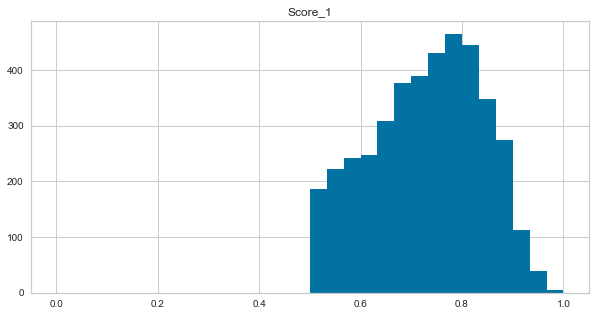

In [28]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

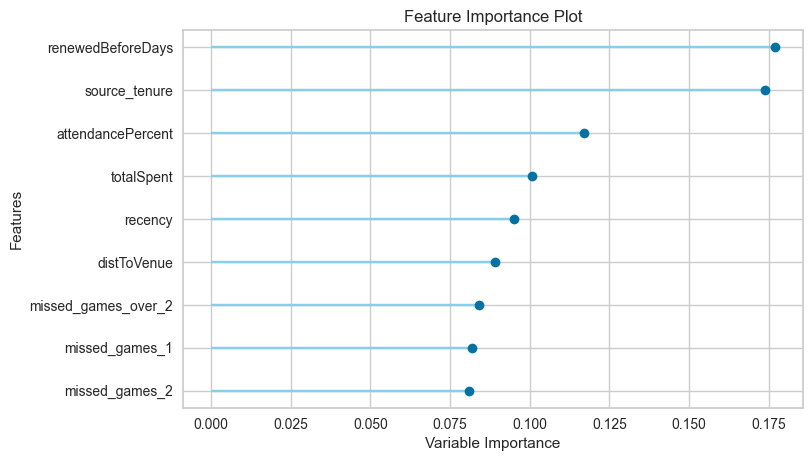

In [29]:
plot_model(best_model, plot='feature')

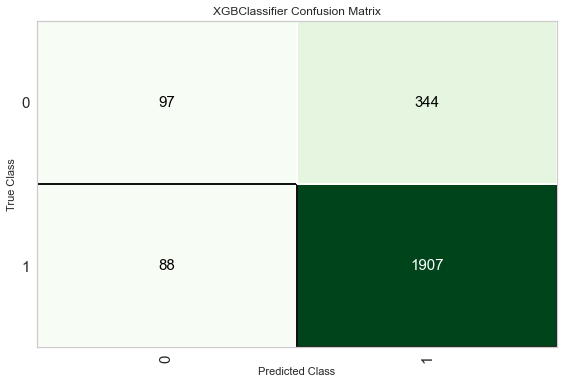

In [30]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?